# Gausssian-Mixture Regression (California Housing Data)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/LightGBMLSS/blob/master/docs/examples/GaussianMixture_Regression_CaliforniaHousing.ipynb)

Mixture densities or mixture distributions offer an extension to the notion of traditional univariate distributions by allowing the observed data to be thought of as arising from multiple underlying processes. In its essence, a mixture distribution is a weighted combination of several component distributions, where each component contributes to the overall mixture distribution, with the weights indicating the importance of each component. For instance, if you imagine the observed data distribution having multiple modes, a mixture of Gaussians could be employed to capture each mode with a separate Gaussian distribution. 

<center>
<img src="https://raw.githubusercontent.com/StatMixedML/LightGBMLSS/master/docs/mixture.png" width=400/>
</center>

For each component of the mixture, there would be a set of parameters that depend on covariates, and additional mixing coefficients which are also modeled as a function of covariates. This is particularly useful when a single parametric distribution cannot adequately capture the underlying data generating process. A mixture distribution can be represented as follows:

\begin{equation}
f\bigl(y_{i} | \boldsymbol{\theta}_{i}(x_{i})\bigr) = \sum_{m=1}^{M} w_{i,m}(x_{i}) \cdot f_{m}\bigl(y_{i} | \boldsymbol{\theta}_{i,m}(x_{i})\bigr)
\end{equation}

where $f(\cdot)$ represents the mixture density for the $i$-th observation, $f_{m}(\cdot)$ is the $m$-th component density, each with its own set of parameters $\boldsymbol{\theta}_{i,m}(\cdot)$, and $w_{i,m}(\cdot)$ represent the weights of the $m$-th component in the mixture, subject to $\sum_{j=1}^{M} w_{i,m} = 1$. The components can either be a combination of different parametric univariate distributions, such as a combination of a Normal and a StudentT, or, as in our implementation, a combination of the same distribution-type with different parameterizations, e.g., Gaussian-Mixture or StudentT-Mixture. The choice of the component distributions depends on the characteristics of the data and the underlying assumptions. Due to their high flexibility, mixture densities can portray a diverse range of shapes, making them adaptable to a plethora of datasets. 

# Imports

In [1]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Gaussian import *
from lightgbmlss.distributions.Mixture import *
from lightgbmlss.distributions.mixture_distribution_utils import MixtureDistributionClass

from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
figure_size = (10,5)
import plotnine
from plotnine import *
plotnine.options.figure_size = figure_size

# Data

In [2]:
housing_data = datasets.fetch_california_housing()
X, y = housing_data["data"], housing_data["target"]
feature_names = housing_data["feature_names"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = lgb.Dataset(X_train, label=y_train)

# Distribution Selection

In the following, we specify a list of candidate distributions. The function dist_select returns the negative log-likelihood of each distribution for the target variable. The distribution with the lowest negative log-likelihood is selected. The function also plots the density of the target variable and the fitted density, using the best suitable distribution among the specified ones. However, note that choosing the best performing mixture-distribution based solely on training data may lead to overfitting, since mixture-densities can approximate any distribution arbitrarily well. It is therefore crucial to carefully select the specifications to strike a balance between model complexity and generalization abilit.
.


Fitting of candidate distributions completed: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.75s/it]


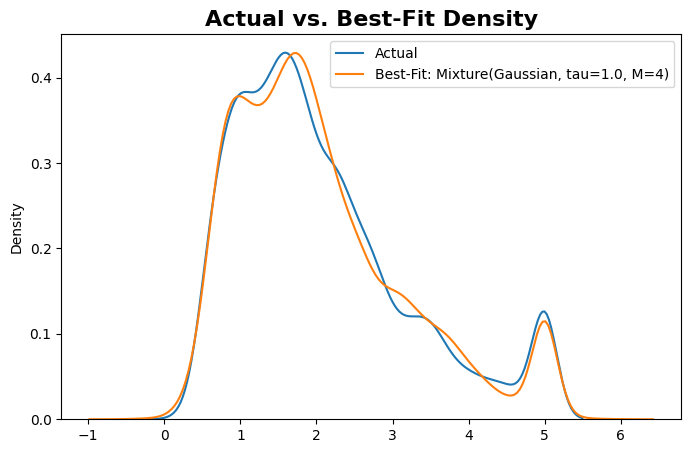

,nll,distribution
rank,,
1,13576.063477,"Mixture(Gaussian, tau=1.0, M=4)"
2,23268.498047,"Mixture(Gaussian, tau=1.0, M=3)"
3,23737.701172,"Mixture(Gaussian, tau=1.0, M=2)"


In [3]:
mix_dist_class = MixtureDistributionClass()

candidate_distributions = [
    Mixture(Gaussian(response_fn="softplus"), M = 2),
    Mixture(Gaussian(response_fn="softplus"), M = 3),
    Mixture(Gaussian(response_fn="softplus"), M = 4),
]

dist_nll = mix_dist_class.dist_select(target=y_train, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(8, 5))
dist_nll

In [4]:
# Specifies a mixture of Gaussians. See ?Mixture for an overview.
lgblss = LightGBMLSS(
    Mixture(
        Gaussian(response_fn="softplus", stabilization="L2"), 
        M = 4,
        tau=1.0,
        hessian_mode="individual",
    )
)

# Hyper-Parameter Optimization

Any LightGBM hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"boosting": ["categorical", ["gbdt", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

In [5]:
param_dict = {
    "eta":                      ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":                ["int",   {"low": 1,      "high": 10,    "log": False}],
    "min_gain_to_split":        ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "min_sum_hessian_in_leaf":  ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "subsample":                ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "feature_fraction":         ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "boosting":                 ["categorical", ["gbdt"]],
}

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=60,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=10,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=True,               # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

  0%|          | 0/10 [00:00<?, ?it/s]


Hyper-Parameter Optimization successfully finished.
  Number of finished trials:  10
  Best trial:
    Value: 445.56917630297374
    Params: 
    eta: 0.20715773912924598
    max_depth: 6
    min_gain_to_split: 9.761200664385873e-06
    min_sum_hessian_in_leaf: 176.34827542147283
    subsample: 0.7488113255108932
    feature_fraction: 0.7896674662565701
    boosting: gbdt
    opt_rounds: 21


# Model Training

In [6]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds,
             )

# Prediction

In [7]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = y_test.shape[0]
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = lgblss.predict(X_test,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(X_test,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = lgblss.predict(X_test,
                             pred_type="parameters")

In [8]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample4118,y_sample4119,y_sample4120,y_sample4121,y_sample4122,y_sample4123,y_sample4124,y_sample4125,y_sample4126,y_sample4127
0,2.162829,2.508204,2.211836,1.925994,1.159945,2.016767,1.666765,1.465553,1.905298,2.127116,...,1.720509,2.041752,1.559268,2.443627,1.721512,2.157196,1.734174,2.159168,2.378182,1.660090
1,0.645621,0.767177,0.597275,0.640497,0.943862,0.832244,0.715083,0.705280,0.821382,1.073743,...,0.358684,0.533696,0.640060,0.778543,0.840135,0.617447,0.545460,0.472524,0.720253,0.836504
2,1.499615,1.031214,1.211547,0.919955,1.336877,0.887903,1.090465,1.403069,1.300663,1.237250,...,0.937330,0.953710,1.644431,1.446580,0.523763,1.715446,1.432942,0.662374,1.752825,1.031723
3,1.631037,1.342607,1.668040,1.453654,1.240595,1.544695,1.516074,1.898920,1.579752,1.554121,...,1.772402,2.077689,1.412837,1.627707,1.633431,1.390825,1.509282,1.608410,1.875204,1.813897
4,3.075264,2.256578,5.085182,1.607093,5.000009,5.051952,2.735735,1.355412,5.000010,2.721089,...,5.000010,5.000007,2.759702,3.853760,2.960375,3.808115,2.495556,4.368052,4.447280,4.765872


In [9]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,1.427683,2.555276
1,0.477882,1.078095
2,0.696525,1.740423
3,1.008263,2.292299
4,2.011817,5.000011


In [10]:
pred_params.head()

,loc_1,loc_2,loc_3,loc_4,scale_1,scale_2,scale_3,scale_4,mix_prob_1,mix_prob_2,mix_prob_3,mix_prob_4
0,5.00001,2.416747,1.969921,3.697778,0.000001,0.053978,0.337029,0.145816,0.001544,0.001843,0.985405,0.011208
1,5.00001,2.477809,0.765513,1.777981,0.000001,0.053978,0.176393,0.750823,0.000344,0.000730,0.978583,0.020344
2,5.00001,2.175382,1.178325,1.478990,0.000001,0.628909,0.299964,0.256762,0.000755,0.006878,0.918231,0.074136
3,5.00001,0.926846,1.581064,2.016363,0.000001,0.024010,0.320568,0.377496,0.003032,0.017145,0.817316,0.162508
4,5.00001,2.504081,3.305460,3.511172,0.000001,0.053978,0.945428,0.773409,0.179498,0.078647,0.417500,0.324355


# SHAP Interpretability

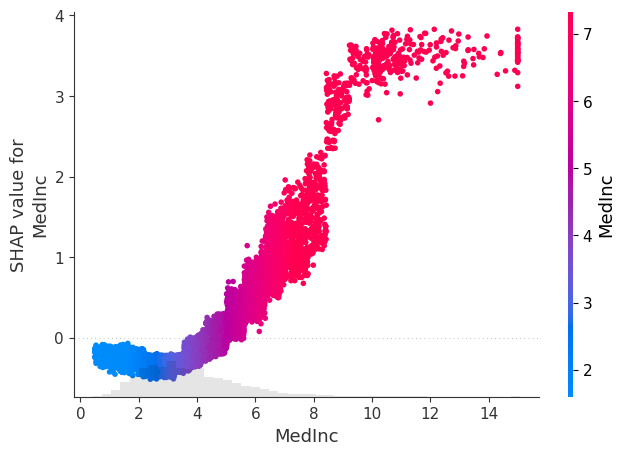

In [11]:
# Partial Dependence Plot
shap_df = pd.DataFrame(X_train, columns=feature_names)
lgblss.plot(shap_df,
            parameter="mix_prob_1",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

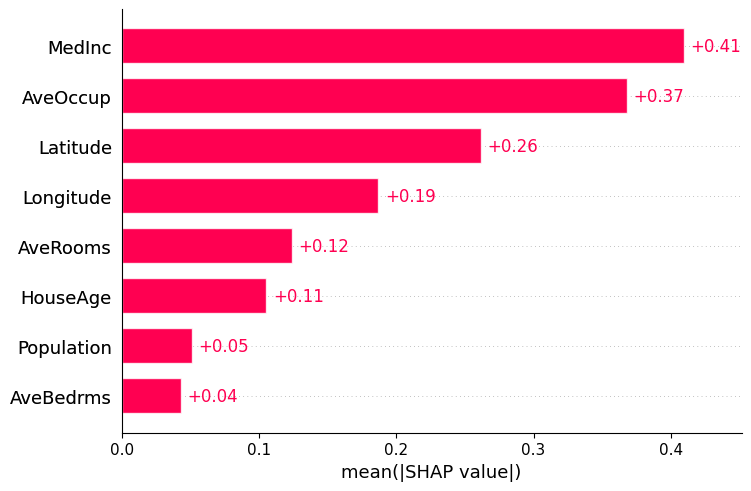

In [12]:
# Feature Importance
lgblss.plot(shap_df,
            parameter="mix_prob_1",
            plot_type="Feature_Importance")

# Density Plots

In the following, we plot the actual and a subsample of the predicted denstites.

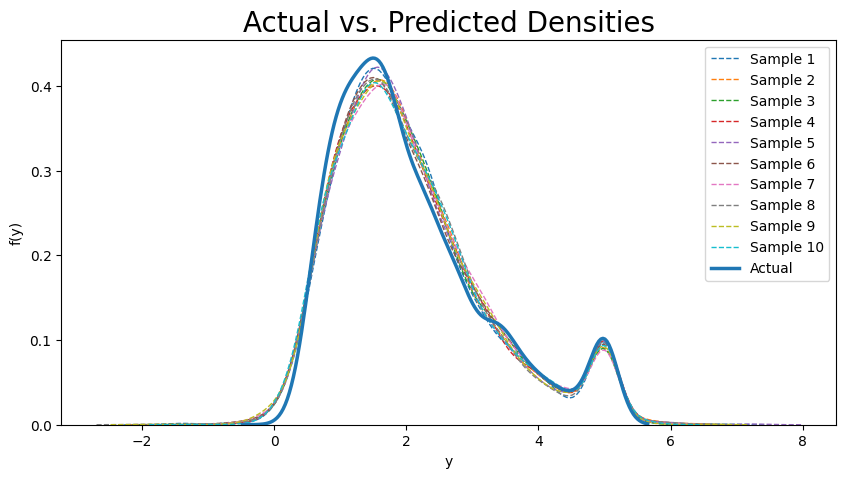

In [13]:
n_subset = 10
pred_df = pred_samples.iloc[:,0:n_subset]
pred_df.columns=[f"Sample {i+1}" for i in range(n_subset)]
actual_df = pd.DataFrame(y_test.reshape(-1,), columns = ["Actual"])
plot_df = pd.concat([pred_df, actual_df], axis=1)
linestyles = ["--" for _ in range(n_subset)] + ["solid"]
linewidths = [1 for _ in range(n_subset)] + [2.5]

plt.figure(figsize=figure_size)
for idx, col in enumerate(plot_df.columns):
    sns.kdeplot(plot_df[col], linestyle=linestyles[idx], lw=linewidths[idx], label=col)
plt.legend()
plt.title("Actual vs. Predicted Densities", fontsize=20)
plt.gca().set_xlabel("y")
plt.gca().set_ylabel("f(y)")
plt.show()

# Component Distributions

We can also plot each Gaussian component distribution.

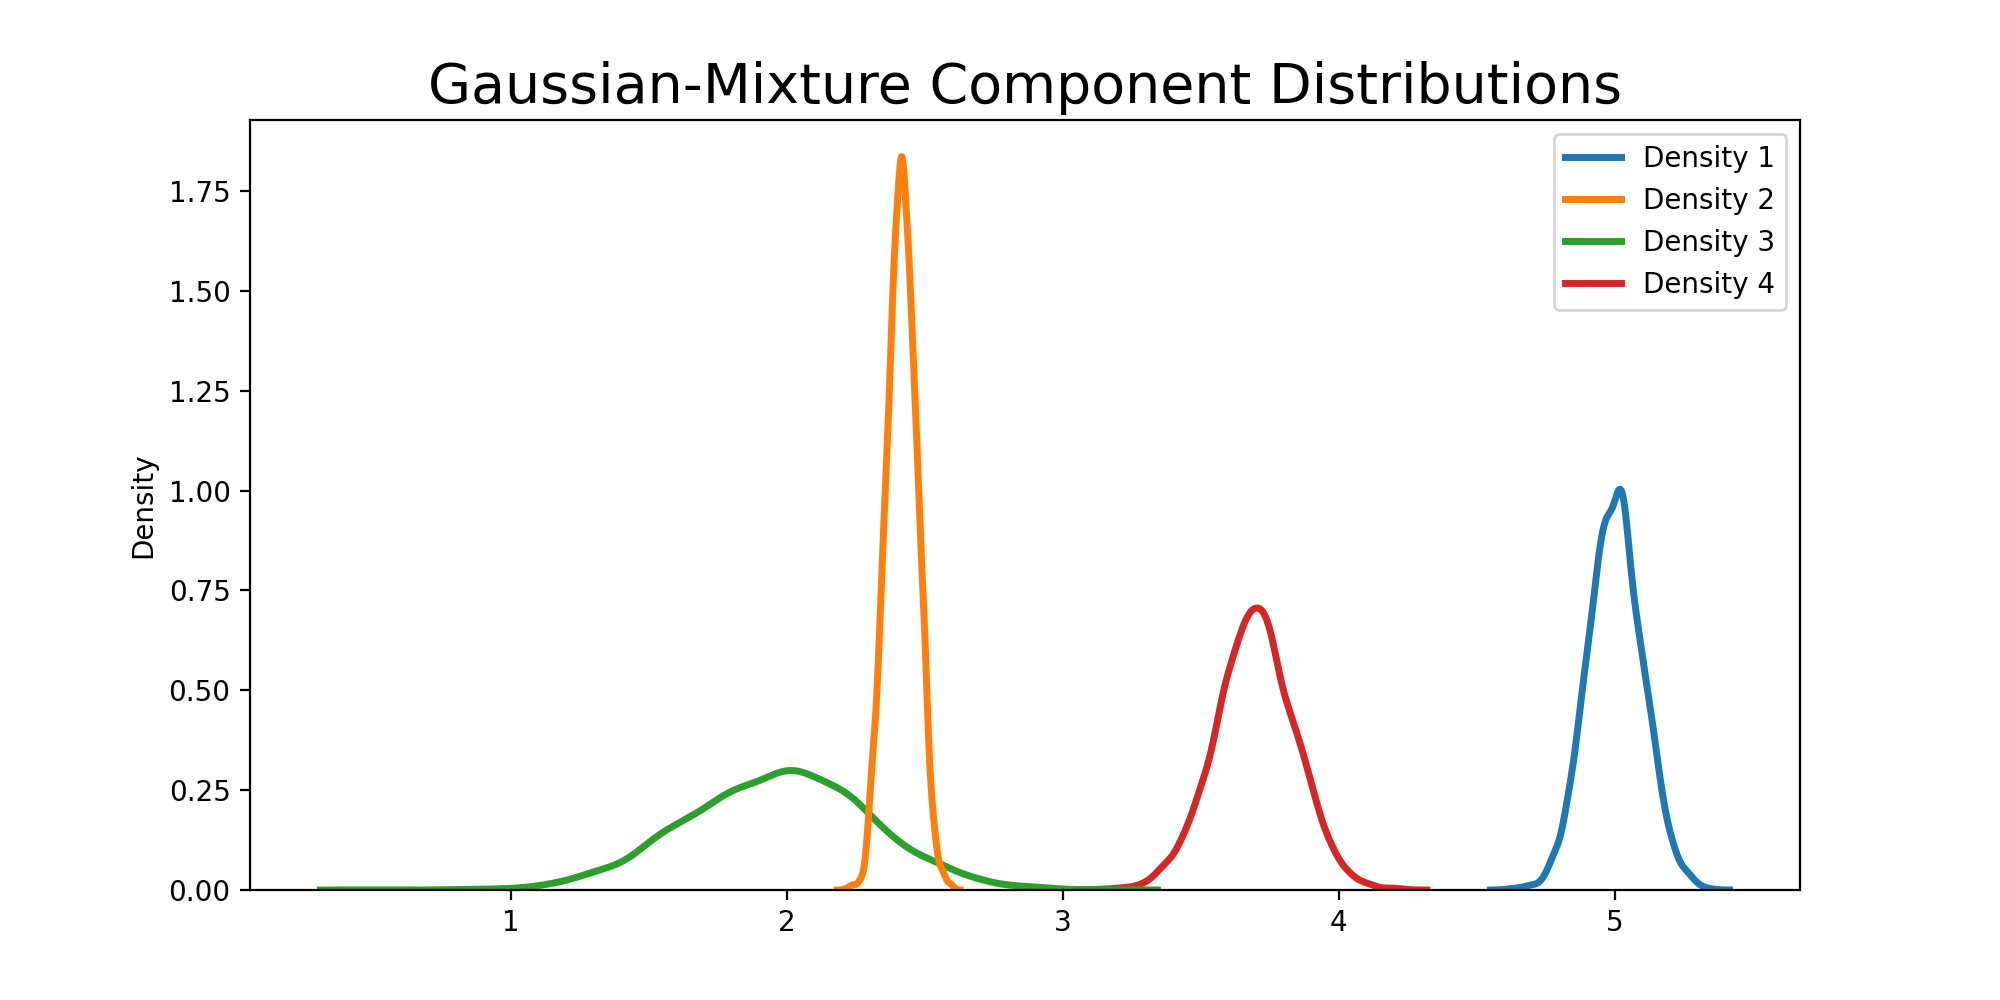

In [24]:
# Extract predicted parameters
mix_params =  torch.split(torch.tensor(pred_params.values[0,:]).reshape(1,-1), lgblss.dist.M, dim=1)
mix_params[1][0][0] = mix_params[1][0][0] + torch.tensor(0.1) # increase the std of the first density for plotting reasons

# Create Mixture-Distribution
torch.manual_seed(123)
mix_dist = lgblss.dist.create_mixture_distribution(mix_params)
gaus_dist = mix_dist._component_distribution
gaus_samples = pd.DataFrame(
    gaus_dist.sample((y_test.shape[0],)).reshape(-1, lgblss.dist.M).numpy(),
    columns = [f"Density {i+1}" for i in range(lgblss.dist.M)]
)

# Plot
plt.figure(figsize=figure_size)
sns.kdeplot(gaus_samples, lw=2.5)
plt.title("Gaussian-Mixture Component Distributions", fontsize=20)
plt.show()

# Actual vs. Predicted

Since we predict the entire conditional distribution, we can overlay the point predictions with predicted densities, from which we can also derive quantiles of interest.

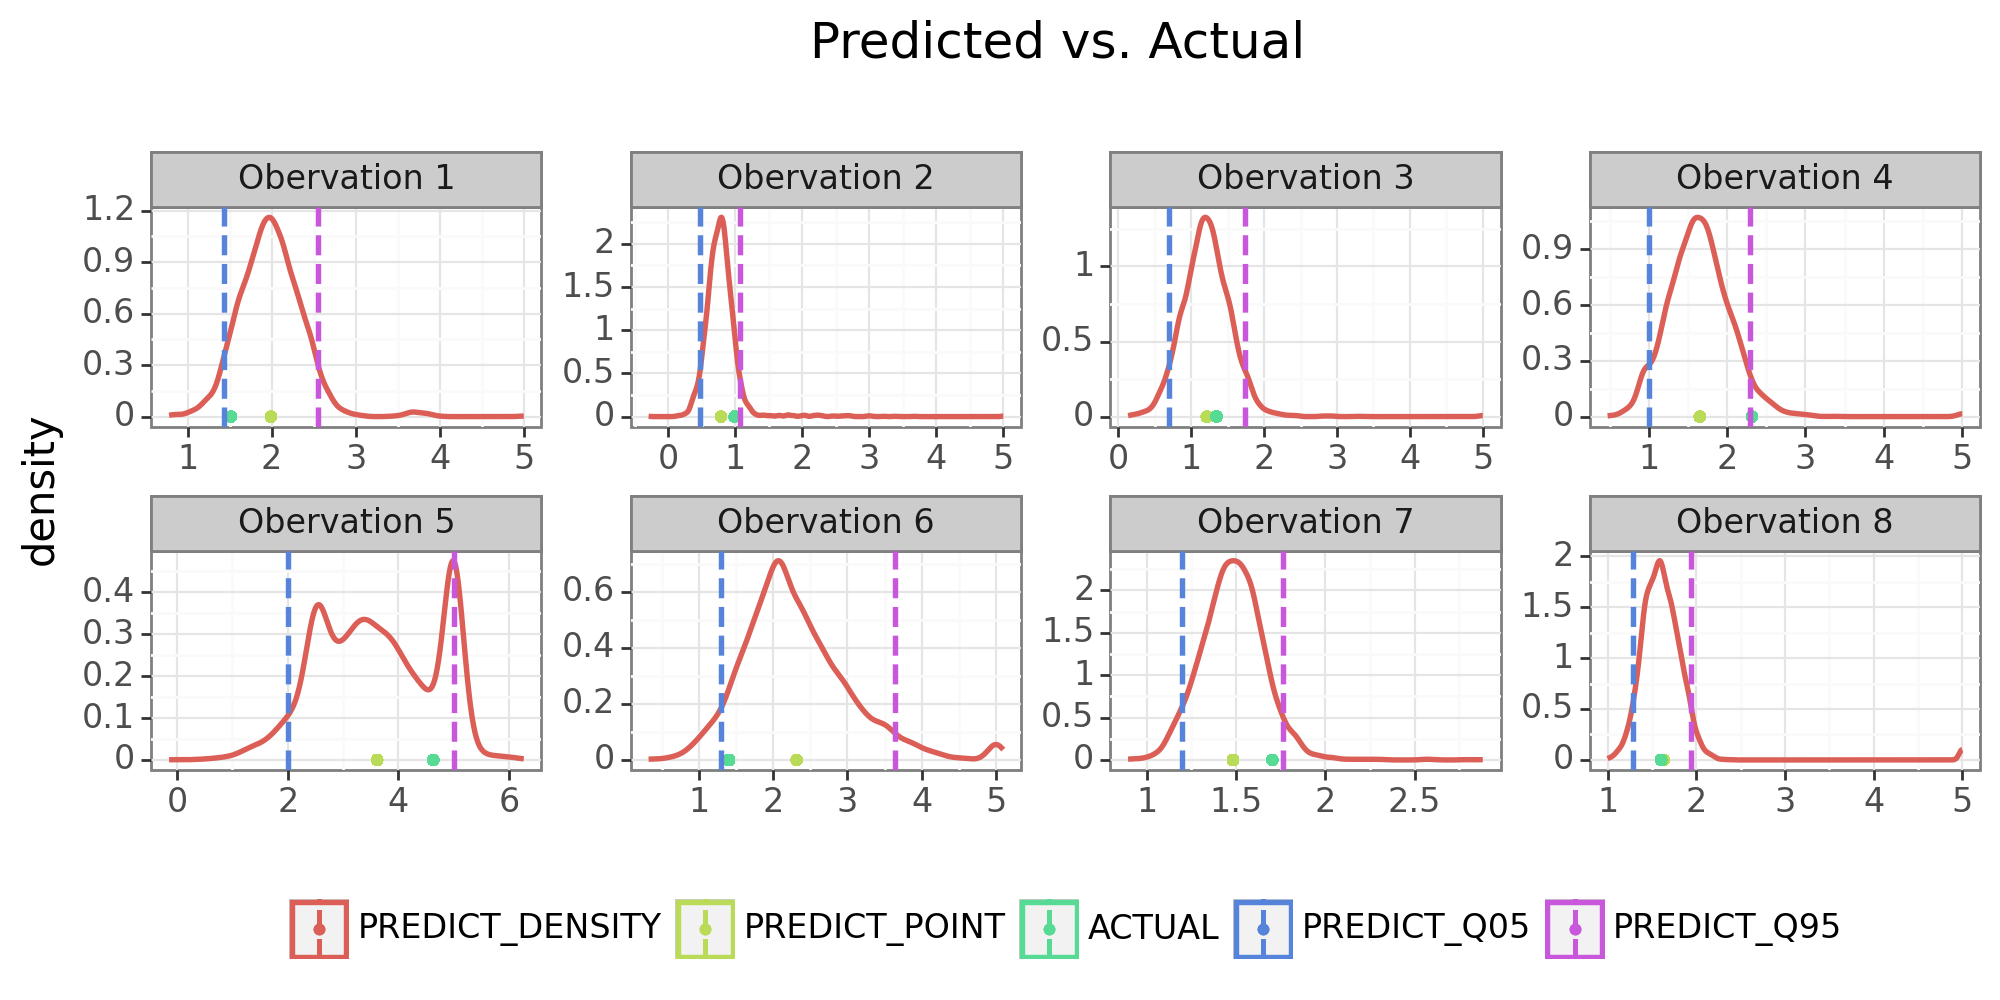

In [15]:
y_pred = []

n_examples = 8
q_sel = [0.05, 0.95]
y_sel=0
samples_arr = pred_samples.values.reshape(-1,n_samples)

for i in range(n_examples):    
    y_samples = pd.DataFrame(samples_arr[i,:].reshape(-1,1), columns=["PREDICT_DENSITY"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENSITY"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENSITY"].quantile(q=q_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENSITY"].quantile(q=q_sel[1])
    y_samples["ACTUAL"] = y_test[i]
    y_samples["obs"]= f"Obervation {i+1}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free",
               ncol=4) + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    theme(plot_title = element_text(hjust = 0.5)) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          legend_title = element_blank()
         )
)

print(plot_pred)